In [2]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

In [3]:
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [4]:
# find out which features have lots of null values
df.isna().sum()

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [5]:
df.value_counts()

passenger_id  survived  pclass  sex     age   sibsp  parch  fare      embarked  class   deck  embark_town  alone
1             1         1       female  38.0  1      0      71.2833   C         First   C     Cherbourg    0        1
571           1         1       female  53.0  2      0      51.4792   S         First   C     Southampton  0        1
577           1         1       female  39.0  1      0      55.9000   S         First   E     Southampton  0        1
581           1         1       female  39.0  1      1      110.8833  C         First   C     Cherbourg    0        1
583           0         1       male    36.0  0      0      40.1250   C         First   A     Cherbourg    1        1
                                                                                                                   ..
325           1         1       female  36.0  0      0      135.6333  C         First   C     Cherbourg    1        1
327           1         2       female  36.0  0      0      1

In [6]:
# how many survivors?
df.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

In [7]:
# Baseline prediction will be mode, which is 0 for did not survive
df['baseline'] = 0
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone,baseline
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1,0
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1,0


In [8]:
# Baseline accuracy:

baseline_accuracy = (df.survived == df.baseline).mean()
print(f'baseline accuracy: {baseline_accuracy:.0%}')

baseline accuracy: 62%


In [9]:
#Replace string values in columns to prepare data for model

df.replace({'sex':{'male':1, 'female':0}}, inplace=True)  #male is 1, female is 0

df.replace({'class':{'First':1, 'Second':2, 'Third':3}}, inplace=True) #First class is 1, Second is 2, and Third is 3

df.replace({'deck':{'A':1, 'B':2, 'C':3}}, inplace=True) #NaN is 0, A is 1, B is 2, C is 3

df.replace({'embark_town':{'Cherbourg':1, 'Southampton':2, 'Queenstown':3}}, inplace=True)

df.replace({'embarked':{'C':1, 'S':2, 'Q':3}}, inplace=True)

df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone,baseline
0,0,0,3,1,22.0,1,0,7.2500,2.0,3,NaN,2.0,0,0
1,1,1,1,0,38.0,1,0,71.2833,1.0,1,3,1.0,0,0
2,2,1,3,0,26.0,0,0,7.9250,2.0,3,NaN,2.0,1,0
3,3,1,1,0,35.0,1,0,53.1000,2.0,1,3,2.0,0,0
4,4,0,3,1,35.0,0,0,8.0500,2.0,3,NaN,2.0,1,0


In [10]:
# drop rows where embark town are null values
df = df[~df.embark_town.isnull()]

In [11]:
# drop rows where age is null values
df = df[~df.age.isnull()]
df

#Or we can impute using the median age because it looks like there's nothing no age folks are way different
#df.age = df.age.fillna(value=df.age.median())
#print(df.age.median())

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone,baseline
0,0,0,3,1,22.0,1,0,7.2500,2.0,3,NaN,2.0,0,0
1,1,1,1,0,38.0,1,0,71.2833,1.0,1,3,1.0,0,0
2,2,1,3,0,26.0,0,0,7.9250,2.0,3,NaN,2.0,1,0
3,3,1,1,0,35.0,1,0,53.1000,2.0,1,3,2.0,0,0
4,4,0,3,1,35.0,0,0,8.0500,2.0,3,NaN,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,885,0,3,0,39.0,0,5,29.1250,3.0,3,NaN,3.0,0,0
886,886,0,2,1,27.0,0,0,13.0000,2.0,2,NaN,2.0,1,0
887,887,1,1,0,19.0,0,0,30.0000,2.0,1,2,2.0,1,0
889,889,1,1,1,26.0,0,0,30.0000,1.0,1,3,1.0,1,0


In [12]:
# drop the deck column
df = df.drop(columns='deck')

In [13]:
#How many nulls are in our dataset?
df.isna().sum()

passenger_id    0
survived        0
pclass          0
sex             0
age             0
sibsp           0
parch           0
fare            0
embarked        0
class           0
embark_town     0
alone           0
baseline        0
dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [15]:
# split into train, validate, test
train, validate, test = train_validate_test_split(df, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable 
# and X are all the features.
# we do this so that we have labeled datasets for training, validating, and testing models

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [16]:
train.shape, validate.shape, test.shape

((398, 13), (171, 13), (143, 13))

In [17]:
X_train.head()

,passenger_id,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,baseline
450,450,2,1,36.0,1,2,27.75,2.0,2,2.0,0,0
543,543,2,1,32.0,1,0,26.00,2.0,2,2.0,0,0
157,157,3,1,30.0,0,0,8.05,2.0,3,2.0,1,0
462,462,1,1,47.0,0,0,38.50,2.0,1,2.0,1,0
397,397,2,1,46.0,0,0,26.00,2.0,2,2.0,1,0


In [18]:
# use the mode as a baseline
baseline = y_train.mode()

matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.6


In [19]:
#Train the model

#Create the Decision Tree object with desired hyper-parameters.

clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [20]:
#Fit the random forest algorithm to the training data.

# model.fit(X, y)

clf = clf.fit(X_train, y_train)

In [21]:
#Graphviz: Visualize the Decision Tree

import graphviz
from graphviz import Graph

dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [22]:
#Make Predictions on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0])

In [23]:
#Estimate the probability using the training data

y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.9010989, 0.0989011],
       [0.9010989, 0.0989011],
       [0.9010989, 0.0989011],
       [0.6      , 0.4      ],
       [0.9010989, 0.0989011]])

In [24]:
#Evaluate the Model

#Compute Accuracy

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.84


In [25]:
#Create a confusion matrix

confusion_matrix(y_train, y_pred)

array([[230,   7],
       [ 56, 105]])

In [26]:
y_train.value_counts()

0    237
1    161
Name: survived, dtype: int64

In [27]:
#Add labels

labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,230,7
1,56,105


In [28]:
#Print classification report

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       237
           1       0.94      0.65      0.77       161

    accuracy                           0.84       398
   macro avg       0.87      0.81      0.82       398
weighted avg       0.86      0.84      0.83       398



In [29]:
#Evaluate the Model with our Validate dataset

#Calculate the accuracy of the model when run on the validate data

print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.78


In [30]:
# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       102
           1       0.88      0.52      0.65        69

    accuracy                           0.78       171
   macro avg       0.81      0.74      0.75       171
weighted avg       0.80      0.78      0.76       171



In [31]:
#Train the model with a max_depth of 2

#Create the Decision Tree object with desired hyper-parameters.

clf = DecisionTreeClassifier(max_depth=2, random_state=123)

In [32]:
clf = clf.fit(X_train, y_train)

In [33]:
dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [34]:
y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0])

In [35]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.83122363, 0.16877637],
       [0.83122363, 0.16877637],
       [0.83122363, 0.16877637],
       [0.83122363, 0.16877637],
       [0.83122363, 0.16877637]])

In [36]:
y_train.value_counts()

0    237
1    161
Name: survived, dtype: int64

In [37]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,228,9
1,66,95


In [38]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       237
           1       0.91      0.59      0.72       161

    accuracy                           0.81       398
   macro avg       0.84      0.78      0.79       398
weighted avg       0.83      0.81      0.80       398



In [39]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.81


In [40]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.77


In [41]:
# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       102
           1       0.86      0.52      0.65        69

    accuracy                           0.77       171
   macro avg       0.80      0.73      0.74       171
weighted avg       0.79      0.77      0.76       171



In [42]:
#Train the model with a max_depth of 4 to compare values

#Create the Decision Tree object with desired hyper-parameters.

clf = DecisionTreeClassifier(max_depth=4, random_state=123)

In [43]:
clf = clf.fit(X_train, y_train)

In [44]:
dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [45]:
y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0])

In [46]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.90607735, 0.09392265],
       [0.90607735, 0.09392265],
       [0.90607735, 0.09392265],
       [0.74285714, 0.25714286],
       [0.90607735, 0.09392265]])

In [47]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.86


In [48]:
confusion_matrix(y_train, y_pred)

array([[215,  22],
       [ 32, 129]])

In [49]:
y_train.value_counts()

0    237
1    161
Name: survived, dtype: int64

In [50]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,215,22
1,32,129


In [51]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       237
           1       0.85      0.80      0.83       161

    accuracy                           0.86       398
   macro avg       0.86      0.85      0.86       398
weighted avg       0.86      0.86      0.86       398



In [52]:
# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       102
           1       0.80      0.64      0.71        69

    accuracy                           0.79       171
   macro avg       0.79      0.76      0.77       171
weighted avg       0.79      0.79      0.78       171



Random forest exercises

Continue working in your model file with titanic data to do the following:

#1 Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire

In [54]:
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [55]:
# clean the columns
df.replace({'sex':{'male':1, 'female':0}}, inplace=True)  #male is 1, female is 0
df = df.drop(columns=["embarked"])
df

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,class,deck,embark_town,alone
0,0,0,3,1,22.0,1,0,7.2500,Third,NaN,Southampton,0
1,1,1,1,0,38.0,1,0,71.2833,First,C,Cherbourg,0
2,2,1,3,0,26.0,0,0,7.9250,Third,NaN,Southampton,1
3,3,1,1,0,35.0,1,0,53.1000,First,C,Southampton,0
4,4,0,3,1,35.0,0,0,8.0500,Third,NaN,Southampton,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,1,27.0,0,0,13.0000,Second,NaN,Southampton,1
887,887,1,1,0,19.0,0,0,30.0000,First,B,Southampton,1
888,888,0,3,0,NaN,1,2,23.4500,Third,NaN,Southampton,0
889,889,1,1,1,26.0,0,0,30.0000,First,C,Cherbourg,1


In [56]:
df.deck.isnull().sum()

688

In [57]:
# Drop deck because there are many nulls
df = df.drop(columns=['deck'])
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,class,embark_town,alone
0,0,0,3,1,22.0,1,0,7.2500,Third,Southampton,0
1,1,1,1,0,38.0,1,0,71.2833,First,Cherbourg,0
2,2,1,3,0,26.0,0,0,7.9250,Third,Southampton,1
3,3,1,1,0,35.0,1,0,53.1000,First,Southampton,0
4,4,0,3,1,35.0,0,0,8.0500,Third,Southampton,1


In [58]:
# Fill empty cells in embark_town with the mode
df.embark_town = df.embark_town.fillna(value = df.embark_town.mode())
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,class,embark_town,alone
0,0,0,3,1,22.0,1,0,7.2500,Third,Southampton,0
1,1,1,1,0,38.0,1,0,71.2833,First,Cherbourg,0
2,2,1,3,0,26.0,0,0,7.9250,Third,Southampton,1
3,3,1,1,0,35.0,1,0,53.1000,First,Southampton,0
4,4,0,3,1,35.0,0,0,8.0500,Third,Southampton,1


In [59]:
# Impute using the median age to fill nulls in age column
df.age = df.age.fillna(value=df.age.median())

In [60]:
# Convert class to numbers
df.replace({'class':{'First':1, 'Second':2, 'Third':3}}, inplace=True)

In [61]:
# Encode non-numerical features
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

# Drop the original columns that we encoded
df = df.drop(columns=['sex', 'embark_town'])

# Stitch the df and the dummy_df together again
df = pd.concat([df, dummy_df], axis=1)
df.head()

,passenger_id,survived,pclass,age,sibsp,parch,fare,class,alone,sex,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,22.0,1,0,7.2500,3,0,1,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0,0,0
2,2,1,3,26.0,0,0,7.9250,3,1,0,0,1
3,3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,4,0,3,35.0,0,0,8.0500,3,1,1,0,1


In [62]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [63]:
# split the data into train, validate, test groups
train, validate, test = train_validate_test_split(df, target='survived', seed=123)

# create X & y version of train
# y is a series with just the target variable
# X has the other features

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [64]:
# Create the Random Forest object with desired hyper-parameters.

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [65]:
# Fit the random forest algorithm to the training data.
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [66]:
# Evaluate importance (weight) of each feature

print(rf.feature_importances_)

[0.15923211 0.041925   0.15341034 0.04056236 0.02592415 0.17125886
 0.06596579 0.0190776  0.28693097 0.01283631 0.0228765 ]


In [67]:
# Make Predictions for survival
y_pred = rf.predict(X_train)

In [68]:
# Estimate Probability

y_pred_proba = rf.predict_proba(X_train)

In [69]:
# Evaluate Model

#Compute the Accuracy

print('Accuracy of random forest classifier on the training data set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on the training data set: 0.97


In [70]:
# Create a confusion matrix

print(confusion_matrix(y_train, y_pred))

[[307   0]
 [ 13 178]]


In [71]:
#Create a classificaiton report

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       307
           1       1.00      0.93      0.96       191

    accuracy                           0.97       498
   macro avg       0.98      0.97      0.97       498
weighted avg       0.97      0.97      0.97       498



In [72]:
#Validate Model

#E Validation on the validate dataset

print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.80


In [73]:
#  Increasing your min_samples_leaf and decreasing max_depth to modify model

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)

In [74]:
# Fit the random forest algorithm to the training data.

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=123)

In [75]:
# Evaluate importance of each feature.

print(rf.feature_importances_)

[0.08528952 0.06400715 0.08601705 0.03818859 0.01779063 0.14027234
 0.09667424 0.02140515 0.4206348  0.01522679 0.01449373]


In [76]:
# Make Predictions
y_pred = rf.predict(X_train)

In [77]:
# Estimate Probability

y_pred_proba = rf.predict_proba(X_train)

In [78]:
# Evaluate Model
#Compute the Accuracy

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.87


In [79]:
#Create a classificaiton report

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       307
           1       0.95      0.69      0.80       191

    accuracy                           0.87       498
   macro avg       0.89      0.83      0.85       498
weighted avg       0.88      0.87      0.86       498



In [80]:
#Validate Model

#Evaluate on validate dataset

print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.81


In [81]:
#  Increasing your min_samples_leaf and decreasing max_depth to modify model

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [82]:
#Fit the random forest algorithm to the training data.

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [83]:
# Evaluate importance of each feature.

print(rf.feature_importances_)

[0.02725946 0.08995596 0.0539292  0.02735767 0.01418157 0.12233894
 0.1283853  0.03211733 0.48010283 0.01189802 0.01247372]


In [84]:
# Make Predictions for survival
y_pred = rf.predict(X_train)

In [85]:
# Estimate Probability

y_pred_proba = rf.predict_proba(X_train)

In [86]:
# Evaluate Model

#Compute the Accuracy

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.83


In [87]:
#Create a classification report

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       307
           1       0.93      0.61      0.74       191

    accuracy                           0.83       498
   macro avg       0.86      0.79      0.81       498
weighted avg       0.85      0.83      0.82       498



In [88]:
#Validate Model

#Evaluate on thr validate dataset

print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.80


In [89]:
#Increasing min_samples_per_leaf, decreasing max_depth

# Let's get loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,18,0.937751,0.803738,0.134013
1,3,17,0.921687,0.799065,0.122621
2,4,16,0.903614,0.789720,0.113895
3,5,15,0.889558,0.799065,0.090493
4,6,14,0.885542,0.799065,0.086477
5,7,13,0.861446,0.794393,0.067053
6,8,12,0.869478,0.808411,0.061067
7,9,11,0.861446,0.799065,0.062380
8,10,10,0.847390,0.794393,0.052997
9,11,9,0.847390,0.789720,0.057670


In [90]:
#What if we increase both min_samples_per_leaf and max_depth¶

# Let's get loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.807229,0.775701,0.031528
1,3,3,0.833333,0.799065,0.034268
2,4,4,0.847390,0.794393,0.052997
3,5,5,0.855422,0.813084,0.042338
4,6,6,0.865462,0.803738,0.061724
5,7,7,0.861446,0.775701,0.085745
6,8,8,0.871486,0.817757,0.053729
7,9,9,0.861446,0.799065,0.062380
8,10,10,0.847390,0.794393,0.052997
9,11,11,0.847390,0.789720,0.057670


<AxesSubplot:xlabel='max_depth', ylabel='difference'>

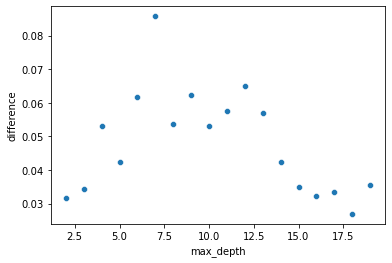

In [91]:
sns.scatterplot(x="max_depth", y="difference", data=df)

In [92]:
#What about a fixed depth and increasing min_samples_leaf

# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 50

for i in range(2, max_depth):
    # Make the model
    depth = 10
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,10,0.937751,0.794393,0.143358
1,3,10,0.915663,0.794393,0.121270
2,4,10,0.903614,0.794393,0.109222
3,5,10,0.887550,0.794393,0.093158
4,6,10,0.881526,0.794393,0.087134
5,7,10,0.865462,0.794393,0.071069
6,8,10,0.867470,0.808411,0.059059
7,9,10,0.859438,0.799065,0.060372
8,10,10,0.847390,0.794393,0.052997
9,11,10,0.845382,0.789720,0.055662


KNN exercises
Continue working in your model file with the titanic dataset.

In [93]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

In [94]:
# Create the KNN Object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [95]:
# Fit the model to the training data.
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [96]:
# Make Predictions
y_pred = knn.predict(X_train)

In [97]:
# Estimate the probability using the training data.
y_pred_proba = knn.predict_proba(X_train)

In [98]:
# Evaluate Model & Compute the Accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.75


In [99]:
# Create a confusion matrix
print(confusion_matrix(y_train, y_pred))

[[266  41]
 [ 85 106]]


In [100]:
# Create a classificaiton report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       307
           1       0.72      0.55      0.63       191

    accuracy                           0.75       498
   macro avg       0.74      0.71      0.72       498
weighted avg       0.74      0.75      0.74       498



In [101]:
# Compute the accuracy of the model when run on the validate dataset.
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.62


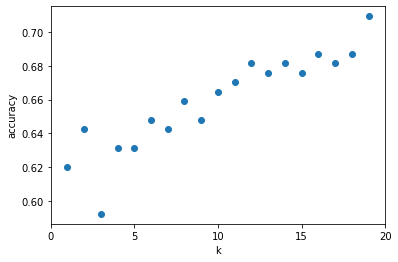

In [102]:
# Visualize the Model
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

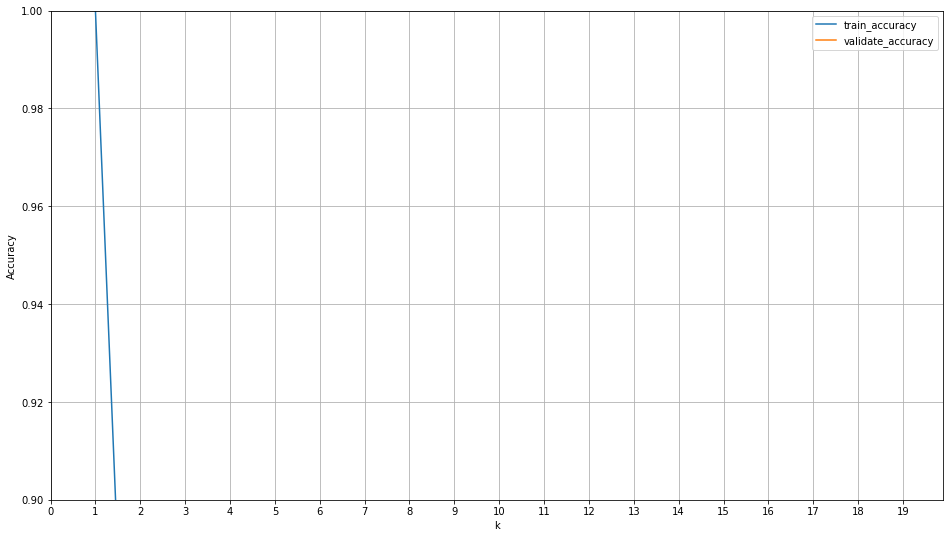

In [103]:
metrics = []

# loop through different values of k
for k in range(1, 20):
            
    # define the model
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the model (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    # use the model (calculate accuracy)
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)

# make a dataframe
results = pd.DataFrame(metrics)

# plot the data
results.set_index('k').plot(figsize = (16,9))
plt.ylim(0.90, 1)
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,20,1))
plt.grid()

In [104]:
#4 Run through steps 2-4 setting k to 10

knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.69


In [105]:
print(confusion_matrix(y_train, y_pred))

[[282  25]
 [127  64]]


In [106]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.92      0.79       307
           1       0.72      0.34      0.46       191

    accuracy                           0.69       498
   macro avg       0.70      0.63      0.62       498
weighted avg       0.70      0.69      0.66       498



In [107]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.62


In [108]:
# Run through setps 2-4 setting k to 20
knn = KNeighborsClassifier(n_neighbors=20, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.67


In [109]:
print(confusion_matrix(y_train, y_pred))

[[290  17]
 [145  46]]


In [110]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.94      0.78       307
           1       0.73      0.24      0.36       191

    accuracy                           0.67       498
   macro avg       0.70      0.59      0.57       498
weighted avg       0.69      0.67      0.62       498



In [111]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.66


In [112]:
# What are the differences in the evaluation metrics? 
# Which performs better on your in-sample data? Why?

# The difference between the two models is the nearest neighbor hyper-parameter
# K=5 worrks best on training data subset

In [113]:
# Which model performs best on our out-of-sample data from validate?

# K=20 works best on validate data subset

Logistic regression exercises

1 Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

In [114]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare

In [115]:
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [116]:
# Prepare the Titanic data 
prepare.prep_titanic(df)

(     passenger_id  survived  pclass     sex        age  sibsp  parch  \
 583           583         0       1    male  36.000000      0      0   
 337           337         1       1  female  41.000000      0      0   
 50             50         0       3    male   7.000000      4      1   
 218           218         1       1  female  32.000000      0      0   
 31             31         1       1  female  29.916875      1      0   
 ..            ...       ...     ...     ...        ...    ...    ...   
 313           313         0       3    male  28.000000      0      0   
 636           636         0       3    male  32.000000      0      0   
 222           222         0       3    male  51.000000      0      0   
 485           485         0       3  female  29.916875      3      1   
 553           553         1       3    male  22.000000      0      0   
 
          fare embarked  class  embark_town  alone  Q  S  
 583   40.1250        C  First    Cherbourg      1  0  0  
 337

In [117]:
train.shape, validate.shape, test.shape

((498, 12), (214, 12), (179, 12))

Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

In [118]:
# this function can be imported by the line below
# from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=1, random_state=123)

In [119]:
# fit the model to the training data

logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=123)

In [120]:
# evaluate the importance of the model features using the coefficients and intercept

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 1.01522539e-03 -1.68690132e-01 -1.17059280e-03 -1.88373839e-01
  -2.28885652e-01  9.05420211e-03 -1.68690132e-01 -1.75646921e-01
  -2.48508686e+00  3.57030858e-01  2.34979197e-01]]
Intercept: 
 [1.11801189]


Make Predictions

In [123]:
# predict the survival of the passengers

y_pred = logit.predict(X_train)

Estimate Probability

In [124]:
# estimate the probability of the passengers surviving

y_pred_proba = logit.predict_proba(X_train)

Evaluate Model

In [125]:
# compute the accuracy of the model

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.80


Create a confusion matrix

In [126]:
print(confusion_matrix(y_train, y_pred))

[[269  38]
 [ 61 130]]


Create a classification report

In [127]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.84       307
           1       0.77      0.68      0.72       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



In [128]:
#Validate Models

# Make predictions on out of sample data

y_pred1 = logit.predict(X_validate)

print("Model 1: solver = lbfgs, c = 1")

# accuracy of model 1
print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 1
print(confusion_matrix(y_validate, y_pred1))

# classification report of model 1
print(classification_report(y_validate, y_pred1))

Model 1: solver = lbfgs, c = 1
Accuracy: 0.77
[[112  20]
 [ 29  53]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       132
           1       0.73      0.65      0.68        82

    accuracy                           0.77       214
   macro avg       0.76      0.75      0.75       214
weighted avg       0.77      0.77      0.77       214



this model has an accuracy of 0.71, so it does does perform better than the baseline

Model 2

In [130]:
# Make the Model
# Create the object to include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.

X_train = train[['age', 'fare', 'class', 'sex']]
y_train = train.survived

X_validate = validate[['age', 'fare', 'class', 'sex']]
y_validate = validate.survived

X_test = test[['age', 'fare', 'class', 'sex']]
y_test = test.survived

In [131]:
#Create the model

logit = LogisticRegression(C=1, random_state=123)

In [132]:
#Fit the model

logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=123)

In [133]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-2.93615278e-02 -2.00493198e-03 -1.21154022e+00 -2.71427548e+00]]
Intercept: 
 [4.82137425]


In [134]:
# make predictions

y_pred = logit.predict(X_train)

In [135]:
# get accuracy of model

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.81


In [136]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       307
           1       0.76      0.73      0.74       191

    accuracy                           0.81       498
   macro avg       0.80      0.79      0.79       498
weighted avg       0.81      0.81      0.81       498



In [137]:
#Validate Models

# Make predictions on out of sample data

y_pred1 = logit.predict(X_validate)

print("Model 2: solver = lbfgs, c = 1")

# accuracy of model 2
print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 2
print(confusion_matrix(y_validate, y_pred1))

# classification report of model 2
print(classification_report(y_validate, y_pred1))


Model 2: solver = lbfgs, c = 1
Accuracy: 0.78
[[111  21]
 [ 26  56]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       132
           1       0.73      0.68      0.70        82

    accuracy                           0.78       214
   macro avg       0.77      0.76      0.76       214
weighted avg       0.78      0.78      0.78       214



Model 3

In [138]:
X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [139]:
#Create the model

logit = LogisticRegression(C=1, random_state=123)

In [140]:
#Fit the model

logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=123)

In [141]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 1.01522539e-03 -1.68690132e-01 -1.17059280e-03 -1.88373839e-01
  -2.28885652e-01  9.05420211e-03 -1.68690132e-01 -1.75646921e-01
  -2.48508686e+00  3.57030858e-01  2.34979197e-01]]
Intercept: 
 [1.11801189]


In [142]:
# make predictions

y_pred = logit.predict(X_train)

In [143]:
# get accuracy 
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.80


In [144]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.84       307
           1       0.77      0.68      0.72       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



In [145]:
#Validate Models

# Make predictions on out of sample data

y_pred1 = logit.predict(X_validate)

print("Model 3: solver = lbfgs, c = 10")

# accuracy of model 3
print('Accuracy on validate: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 3
print(confusion_matrix(y_validate, y_pred1))

# classification report of model 3
print(classification_report(y_validate, y_pred1))

Model 3: solver = lbfgs, c = 10
Accuracy on validate: 0.77
[[112  20]
 [ 29  53]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       132
           1       0.73      0.65      0.68        82

    accuracy                           0.77       214
   macro avg       0.76      0.75      0.75       214
weighted avg       0.77      0.77      0.77       214



Model 4

In [146]:
X_train = train[['age', 'fare', 'class', 'sex']]
y_train = train.survived

X_validate = validate[['age', 'fare', 'class', 'sex']]
y_validate = validate.survived

X_test = test[['age', 'fare', 'class', 'sex']]
y_test = test.survived

In [147]:
#Create the model

logit = LogisticRegression(C=0.1, random_state=123)

In [148]:
#Fit the model

logit.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=123)

In [149]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-2.34435682e-02  7.62468559e-04 -8.46566801e-01 -1.80647943e+00]]
Intercept: 
 [3.21048959]


In [150]:
# make predictions

y_pred = logit.predict(X_train)

In [151]:
# get accuracy 

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.80


In [152]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       307
           1       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



In [153]:
#Validate Models

# Make predictions on out of sample data

y_pred1 = logit.predict(X_validate)

print("Model 4: solver = lbfgs, c = ")

# accuracy of model 4
print('Accuracy on validate: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 4
print(confusion_matrix(y_validate, y_pred1))

# classification report of model 4
print(classification_report(y_validate, y_pred1))

Model 4: solver = lbfgs, c = 
Accuracy on validate: 0.79
[[115  17]
 [ 28  54]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       132
           1       0.76      0.66      0.71        82

    accuracy                           0.79       214
   macro avg       0.78      0.76      0.77       214
weighted avg       0.79      0.79      0.79       214



In [154]:
# Evaluate best model on Test 

logit = LogisticRegression(C=0.1, random_state=123)
logit.fit(X_test, y_test)


y_pred_test = logit.predict(X_test)

print("Test")

# accuracy of model 4
print('Accuracy on test: {:.2f}'.format(logit.score(X_test, y_test)))

# confusion matrix of model 4
print(confusion_matrix(y_test, y_pred_test))

# classification report of model 4
print(classification_report(y_test, y_pred_test))

Test
Accuracy on test: 0.78
[[103   7]
 [ 33  36]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       110
           1       0.84      0.52      0.64        69

    accuracy                           0.78       179
   macro avg       0.80      0.73      0.74       179
weighted avg       0.79      0.78      0.76       179

